## Trabalho de regressão multivariável de um dataset de diamantes

Disciplina: Introdução ao Aprendizado de Máquina (EEL891) <br>
Professor: Heraldo Luís Silveira de Almeida <br>
Aluno: Pedro Felipe Leal Pedrosa (DRE: 113210411)

### 1. Importando as bibliotecas

In [1]:
# Ignorando alguns tipos de erro
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas de manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para pré-processamento, modelo e métricas
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

### 2. Análise e manipulação dos dados

#### 2.1 Leitura

<p>Realizando uma breve visualização prévia dos conjuntos de dados fornecidos (em excel), temos um dataset "train.csv" que possui todos os preços (target) e será usado parcialmente para treinar e avaliar o modelo. O dataset "test.csv" não possui os preços, então só será usado ao final, onde o dataset "train.csv" será integralmente utilizado para predizer os preços do dataset "test.csv" e as predições serão enviadas para o kaggle para cálculo da pontuação.</p>
<p>Dado isso, as análises serão feitas no dataset "train.csv" e, quando necessário, algumas manipulações serão replicadas ao "test.csv", para que ele fique preparado para receber o modelo.</p>

In [2]:
ds = pd.read_csv('data/train.csv')
x_kaggle = pd.read_csv('data/test.csv')

#### 2.2 Análise e manipulação inicial

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33940 entries, 0 to 33939
Data columns (total 11 columns):
id         33940 non-null int64
carat      33940 non-null float64
cut        33940 non-null object
color      33940 non-null object
clarity    33940 non-null object
x          33940 non-null float64
y          33940 non-null float64
z          33940 non-null float64
depth      33940 non-null float64
table      33940 non-null float64
price      33940 non-null int64
dtypes: float64(6), int64(2), object(3)
memory usage: 2.8+ MB


In [4]:
ds.head()

id  carat        cut color clarity     x     y     z  depth  table  \
0  20000   0.35  Very Good     G    VVS2  4.44  4.48  2.80   62.8   58.0   
1  20001   0.70      Ideal     F     SI1  5.66  5.69  3.55   62.6   56.0   
2  20002   0.32      Ideal     F    VVS1  4.42  4.38  2.70   61.4   56.0   
3  20003   0.30      Ideal     H    VVS2  4.32  4.35  2.67   61.7   54.2   
4  20004   0.33    Premium     I    VVS2  4.41  4.47  2.76   62.2   59.0   

   price  
0    798  
1   2089  
2    990  
3    631  
4    579

In [5]:
# Setando o index = id
ds = ds.set_index('id')
x_kaggle = x_kaggle.set_index('id')

In [6]:
ds.describe()

carat             x             y             z         depth  \
count  33940.000000  33940.000000  33940.000000  33940.000000  33940.000000   
mean       0.796249      5.727926      5.730563      3.535916     61.746491   
std        0.472866      1.119282      1.120279      0.693763      1.425570   
min        0.200000      0.000000      0.000000      0.000000     43.000000   
25%        0.400000      4.710000      4.720000      2.910000     61.000000   
50%        0.700000      5.700000      5.710000      3.520000     61.800000   
75%        1.040000      6.540000      6.530000      4.030000     62.500000   
max        5.010000     10.740000     31.800000      6.980000     79.000000   

              table         price  
count  33940.000000  33940.000000  
mean      57.467664   3920.022864  
std        2.237116   3980.229999  
min       44.000000    326.000000  
25%       56.000000    952.000000  
50%       57.000000   2395.000000  
75%       59.000000   5294.000000  
max       95.000000  18823.000000

Temos valores mínimos de x, y e z zerados, sendo que os valores de depth e table calculados baseados nesses valores não apresentam valores zerados. Logo, excluiremos as linhas onde x, y ou z são zero.

In [7]:
# Remoção das linhas com x,y ou z zerados
ds = ds[(ds[['x','y','z']] != 0).all(axis = 1)]

# Apenas testando para confirmar que os valores zerados foram excluidos
print((ds.x == 0).sum())
print((ds.y == 0).sum())
print((ds.z == 0).sum())
print((ds.depth == 0).sum())

0
0
0
0


In [8]:
ds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
price      0
dtype: int64

Não temos nenhum valor null, logo não precisamos tratar.

In [9]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33929 entries, 20000 to 53939
Data columns (total 10 columns):
carat      33929 non-null float64
cut        33929 non-null object
color      33929 non-null object
clarity    33929 non-null object
x          33929 non-null float64
y          33929 non-null float64
z          33929 non-null float64
depth      33929 non-null float64
table      33929 non-null float64
price      33929 non-null int64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.8+ MB


#### 2.3 Análise dos atributos numéricos

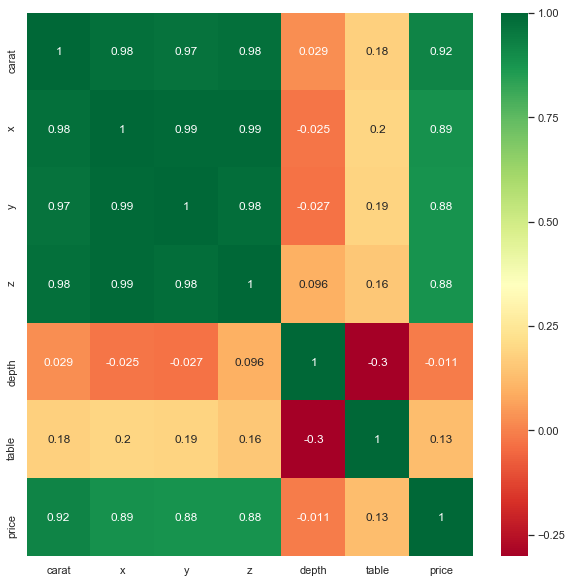

In [10]:
sns.set(palette = "Spectral")
plt.figure(figsize = (10, 10))
sns.heatmap(ds.corr(), annot = True, cmap = 'RdYlGn')
plt.show()

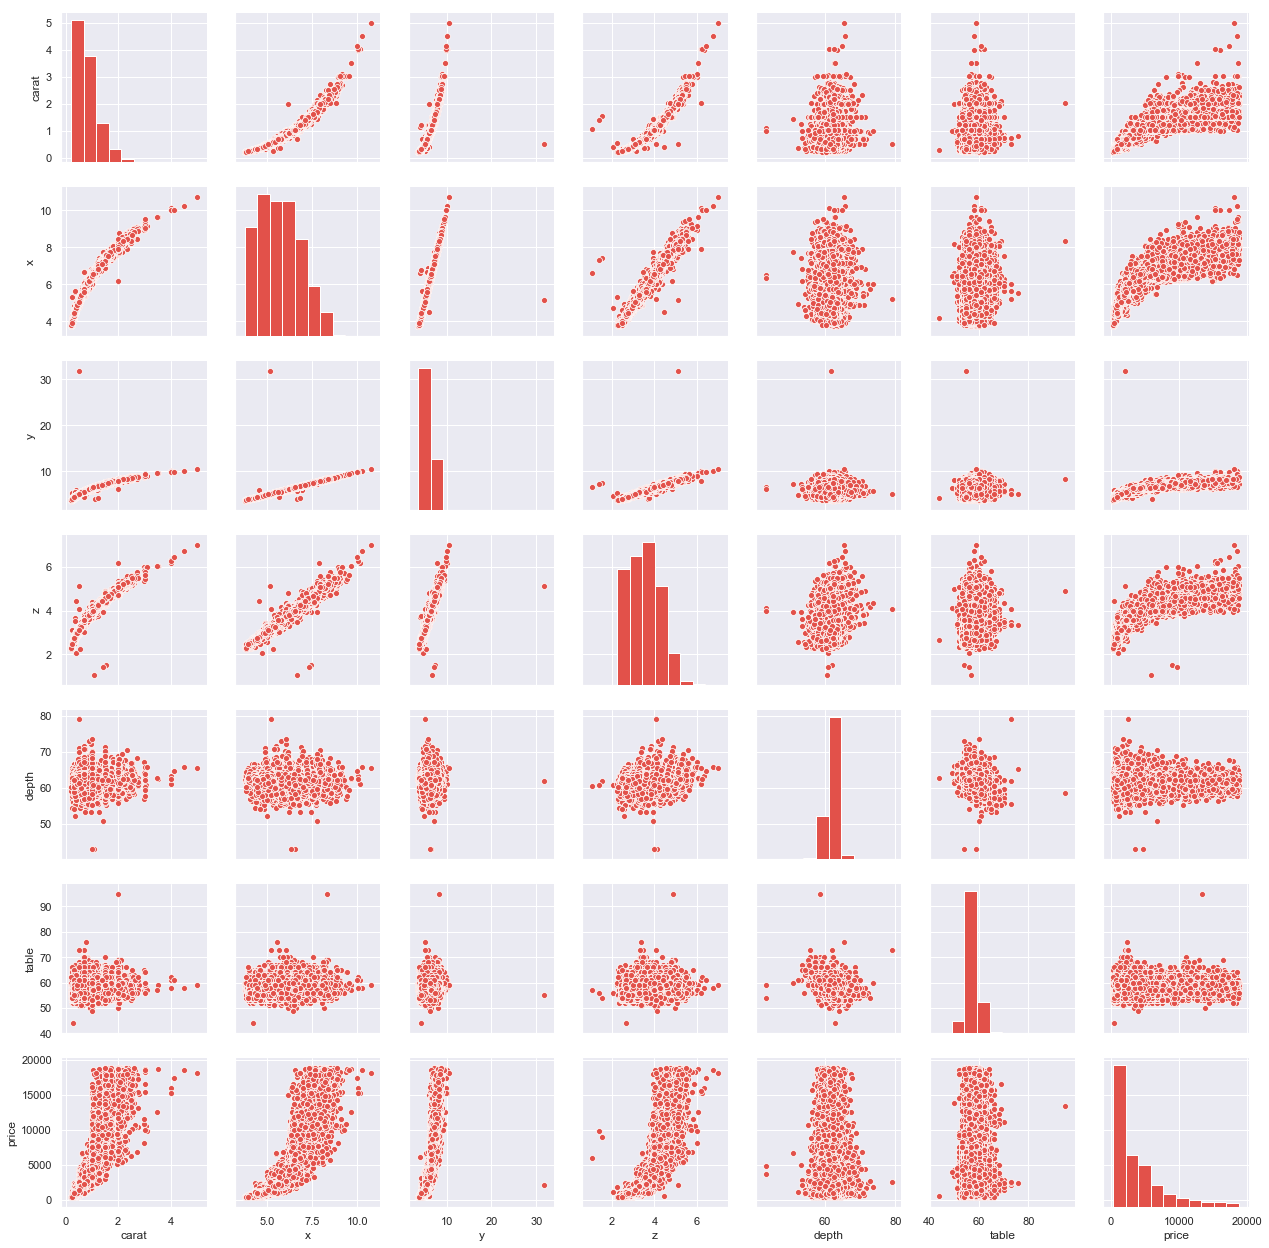

In [11]:
sns.pairplot(ds)
plt.show()

Observações:
<ul>
    <li>Os atributos x, y, z e carat possuem grande correlação com preço, mas também possuem grande correlação entre si</li>
    <li>Os atributos depth e table são baseados em x, y e z, mas não possuem correlação direta com o preço</li>
</ul>

In [12]:
# cols = ds.columns
# is_numeric = pd.api.types.is_numeric_dtype

# # plotando para valores numericos
# for col in cols:
#     if(is_numeric(ds[col]) and col != 'price'):
#         ds.plot.scatter(x = col, y = 'price', c = 'darkred')

#### 2.4 Análise dos atributos categóricos

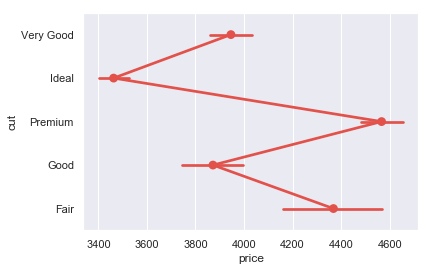

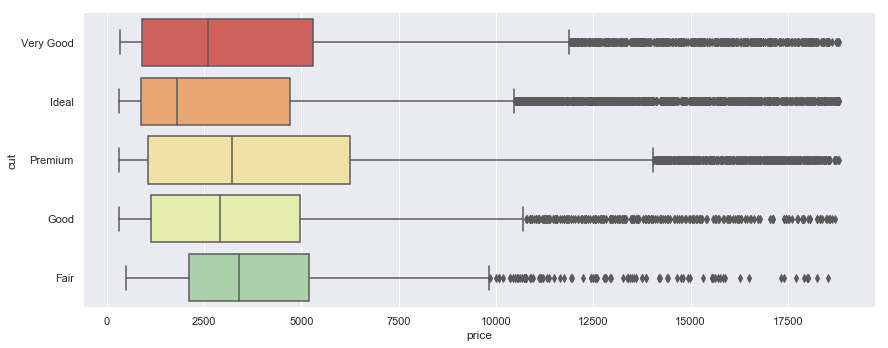

In [13]:
sns.pointplot(x = 'price', y = 'cut', data = ds, orient = 'h')
sns.catplot(x = 'price', y = 'cut', data = ds, kind = 'box', orient = 'h', aspect = 2.5)
plt.show()

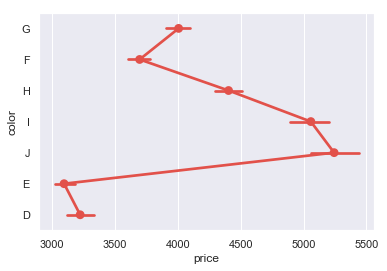

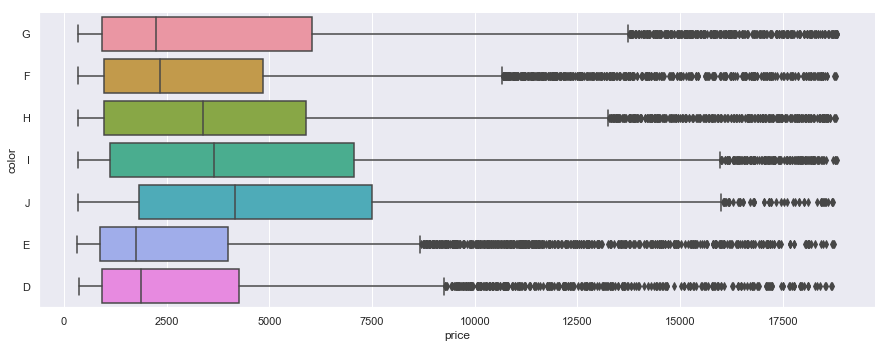

In [14]:
sns.pointplot(x = 'price', y = 'color', data = ds, orient = 'h')
sns.catplot(x = 'price', y = 'color', data = ds, kind = 'box', orient = 'h', aspect = 2.5)
plt.show()

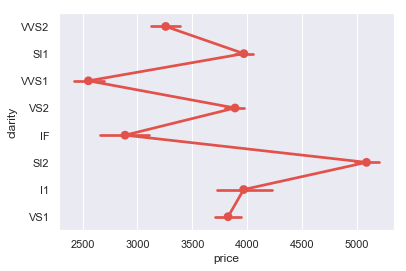

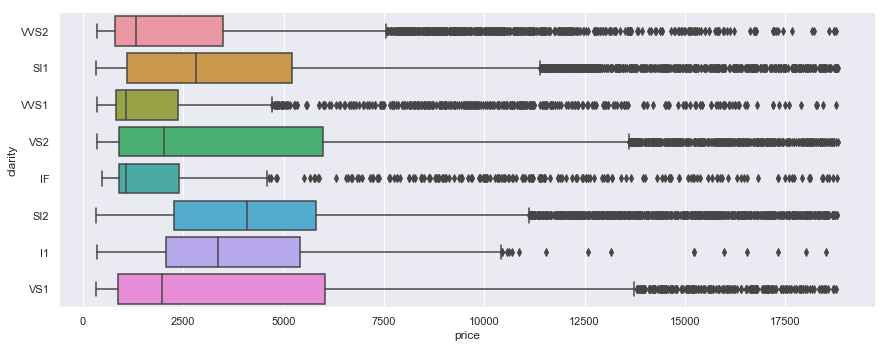

In [15]:
sns.pointplot(x = 'price', y = 'clarity', data = ds, orient = 'h')
sns.catplot(x = 'price', y = 'clarity', data = ds, kind = 'box', orient = 'h', aspect = 2.5)
plt.show()

<p>Observações:
<ul>
    <li>Comparado com carat, x, y e z, os atributos cut, color e clarity não parecem ter uma correlação tão alta com preço</li>
    <li>A mediana e média são relativamente baixas, enquanto que a variação do preço é extremamente alta para qualquer categoria, o que mostra que a influência dessas categorias sobre o preço não é tão alta</li>
</ul>
</p>

<p>Conclusão: Apesar das observações, isso não quer dizer que esses atributos não sejam importantes. Dado um preço genérico de um diamante, estimado puramente pelas dimensões x, y e z, essas categorias podem ser cruciais para fazer o "fine-tuning" do preço final e isso pode contribuir significativamente para métricas como o RMSPE que leva muito em consideração os erros de casos individuais.</p>

#### 2.5 Tratamento para atributos categóricos

<p>Para alimentarmos os modelos do sklearn, precisamos primeiramente transformar os atributos categóricos em atributos numéricos. Existem duas formas de se fazer isso:
<ol>
    <li>Integer Encoding: trata-se de manter o atributo, mas atribuir um inteiro numérico para cada categoria</li>
    <li>One Hot Encoding: trata-se de elimitar o atributo e criar um atributo booleano para cada categoria</li>
</ol>
Com isso em mente, dois datasets serão criados, um para cada método.
</p>

In [16]:
cut_means = ds.groupby('cut', sort = True)['price'].mean()
color_means = ds.groupby('color', sort = True)['price'].mean()
clarity_means = ds.groupby('clarity', sort = True)['price'].mean()

print(cut_means.reset_index().sort_values(['price'], ascending = False).set_index(['cut']))
print(color_means.reset_index().sort_values(['price'], ascending = False).set_index(['color']))
print(clarity_means.reset_index().sort_values(['price'], ascending = False).set_index(['clarity']))

                 price
cut                   
Premium    4566.699759
Fair       4368.407446
Very Good  3946.085684
Good       3872.001933
Ideal      3462.784224
             price
color             
J      5243.350315
I      5058.310035
H      4404.073124
G      4007.062687
F      3697.201471
D      3224.325472
E      3096.514071
               price
clarity             
SI2      5087.433758
SI1      3970.176671
I1       3968.155650
VS2      3889.358846
VS1      3826.168559
VVS2     3257.689121
IF       2887.105778
VVS1     2553.404691


In [17]:
lb = LabelEncoder()
ds_ie = ds.copy()
ds_ohe = ds.copy()
x_kaggle_ie = x_kaggle.copy()

# # Integer encoding
# # ds_ie['cut'] = lb.fit_transform(ds_ie['cut'])
# # ds_ie['color'] = lb.fit_transform(ds_ie['color'])
# # ds_ie['clarity'] = lb.fit_transform(ds_ie['clarity'])
# # # x_kaggle['cut'] = lb.fit_transform(X_kaggle['cut'])
# # # x_kaggle['color'] = lb.fit_transform(X_kaggle['color'])
# # # x_kaggle['clarity'] = lb.fit_transform(X_kaggle['clarity'])

ds_ie['cut'] = ds_ie['cut'].replace({'Ideal': 3462, 'Good': 3872, 'Very Good': 3946, 'Fair': 4368, 'Premium': 4566}, inplace = False)
ds_ie['color'] = ds_ie['color'].replace({'E': 3096, 'D': 3224, 'F': 3697, 'G': 4007, 'H': 4404, 'I': 5058, 'J': 5243}, inplace = False)
ds_ie['clarity'] = ds_ie['clarity'].replace({'VVS1': 2553, 'IF': 2887, 'VVS2': 3257, 'VS1': 3826, 'VS2': 3889, \
                                                 'SI1': 3968, 'I1': 3970, 'SI2': 5087}, inplace = False)
x_kaggle_ie['cut'] = x_kaggle_ie['cut'].replace({'Ideal': 3462, 'Good': 3872, 'Very Good': 3946, 'Fair': 4368, 'Premium': 4566}, inplace = False)
x_kaggle_ie['color'] = x_kaggle_ie['color'].replace({'E': 3096, 'D': 3224, 'F': 3697, 'G': 4007, 'H': 4404, 'I': 5058, 'J': 5243}, inplace = False)
x_kaggle_ie['clarity'] = x_kaggle_ie['clarity'].replace({'VVS1': 2553, 'IF': 2887, 'VVS2': 3257, 'VS1': 3826, 'VS2': 3889, \
                                                 'SI1': 3968, 'I1': 3970, 'SI2': 5087}, inplace = False)

# ds_ie['cut'] = ds_ie['cut'].replace({'Ideal': 1, 'Good': 2, 'Very Good': 3, 'Fair': 4, 'Premium': 5}, inplace = False)
# ds_ie['color'] = ds_ie['color'].replace({'E': 1, 'D': 2, 'F': 3, 'G': 4, 'H': 5, 'I': 6, 'J': 7}, inplace = False)
# ds_ie['clarity'] = ds_ie['clarity'].replace({'VVS1': 1, 'IF': 2, 'VVS2': 3, 'VS1': 4, 'VS2': 5, \
#                                                  'SI1': 6, 'I1': 7, 'SI2': 8}, inplace = False)
# x_kaggle_ie['cut'] = x_kaggle_ie['cut'].replace({'Ideal': 1, 'Good': 2, 'Very Good': 3, 'Fair': 4, 'Premium': 5}, inplace = False)
# x_kaggle_ie['color'] = x_kaggle_ie['color'].replace({'E': 1, 'D': 2, 'F': 3, 'G': 4, 'H': 5, 'I': 6, 'J': 7}, inplace = False)
# x_kaggle_ie['clarity'] = x_kaggle_ie['clarity'].replace({'VVS1': 1, 'IF': 2, 'VVS2': 3, 'VS1': 4, 'VS2': 5, \
#                                                  'SI1': 6, 'I1': 7, 'SI2': 8}, inplace = False)

# One hot encoding
ds_ohe =  pd.get_dummies(ds)
# x_kaggle =  pd.get_dummies(kaggle)

# # Criação de novo atributo
# ds['volume'] = ds['x']*ds['y']*ds['z']
# x_kaggle['volume'] = x_kaggle['x']*x_kaggle['y']*x_kaggle['z']

# ds_ohe.head()

In [18]:
# # Remoção de x, y e z
# ds = ds.drop(['x','y','z'], axis=1)
# kaggle = kaggle.drop(['x','y','z'], axis=1)

# ds = ds.drop(['volume','cut'], axis=1)
# kaggle = kaggle.drop(['volume','cut'], axis=1)

# ds.head()

In [ ]:
# Criando as arrays de treino e test
x_ie = ds_ie.copy().drop(['price'], axis=1)
y_ie = ds_ie.copy()['price']

x_ohe = ds_ohe.copy().drop(['price'], axis=1)
y_ohe = ds_ohe.copy()['price']

x_train_ie, x_test_ie, y_train_ie, y_test_ie = train_test_split(x_ie, y_ie, test_size = 0.3, random_state = 77)
x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = train_test_split(x_ohe, y_ohe, test_size = 0.3, random_state = 77)

# Usar no modelo de envio
x_train = ds_ie.copy().drop(['price'], axis=1)
y_train = ds_ie.copy()['price']

In [20]:
# Criando função que calcula o RMSPE, que será usada para avaliar os modelos
def rmspe_score(y_test, y_pred):
    
    rmspe = np.sqrt(np.mean(np.square(((y_test - y_pred) / y_test)), axis = 0))

    return rmspe

In [21]:
# Generic regression function
def reg(x_train, x_test, y_train, y_test, func, title):

    func.fit(x_train , y_train)
    # accuracies = cross_val_score(estimator = func, X = X_train, y = y_train, cv = 5,verbose = 1)
    y_pred = func.predict(x_test)
    
    print(title)
    print('Score : %.4f' % func.score(x_test, y_test))
    # print(accuracies)

    rmspe = rmspe_score(y_test, y_pred)

    print('RMSPE  : %0.4f ' % rmspe)

In [22]:
lr = LinearRegression()

# Linear Regression com integer encoding
title = '####### Linear Regression IE #######'
reg(x_train_ie, x_test_ie, y_train_ie, y_test_ie, lr, title)

print('')

# Linear Regression com one hot encoding
title = '####### Linear Regression OHE #######'
reg(x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe, lr, title)

####### Linear Regression IE #######
Score : 0.8808
RMSPE  : 0.7482 

####### Linear Regression OHE #######
Score : 0.9134
RMSPE  : 0.7854 


In [23]:
rfr = RandomForestRegressor(n_estimators = 100, max_features = 'auto', random_state = 77)

# Random Forest Regression com integer encoding
title = '####### Random Forest Regression IE #######'
reg(x_train_ie, x_test_ie, y_train_ie, y_test_ie, rfr, title)    

# print('')

# # Random Forest Regression com one hot encoding
# title = '####### Random Forest Regression OHE #######'
# reg(x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe, rfr, title)

####### Random Forest Regression IE #######
Score : 0.9812
RMSPE  : 0.0987 


In [24]:
etr = ExtraTreesRegressor(n_estimators = 100, max_features = 'auto', random_state = 77)

# Extra Trees Regression com integer encoding
title = '####### Extra Trees Regression IE #######'
reg(x_train_ie, x_test_ie, y_train_ie, y_test_ie, etr, title)

print('')

# Extra Trees Regression com one hot encoding
title = '####### Extra Trees Regression OHE #######'
reg(x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe, etr, title)

####### Extra Trees Regression IE #######
Score : 0.9796
RMSPE  : 0.1086 

####### Extra Trees Regression OHE #######
Score : 0.9805
RMSPE  : 0.1098 


In [25]:
## procurando os melhores parametros para o random forest
# param_grid = [
# {'n_estimators': [100], 'max_features': [8, 9]}
# ]

# rf = RandomForestRegressor(random_state = 7)

# gs = GridSearchCV(rf, param_grid, cv = 5, scoring = make_scorer(rmspe_score))
# gs.fit(X_train, y_train)
# gs.best_params_

In [26]:
# rfr = RandomForestRegressor(n_estimators = 100, max_features = 'auto', random_state = 77)
# rfr.fit(x_train , y_train)
# y_kaggle = rfr.predict(x_kaggle)
# submission = pd.DataFrame({'id':x_kaggle_ie.index, 'price':y_kaggle})
# submission.to_csv('submission.csv', index = False)